# RNN作业

本次作业我们将使用PyTorch搭建RNN模型，完成简单的文本分类任务。本次作业的选做题难度较大，仅供有自然语言处理基础且时间充裕的同学完成。

截止时间：<font color=ff0000>**5.30(周一)中午** </font>

## 一、数据处理

首先导入常用软件包。

In [13]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt 
from sklearn import datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import pandas as pd

import os
import glob
from sklearn.model_selection import train_test_split
import spacy
import numpy as np
from torchtext.legacy import data
import torchtext
from tqdm import tqdm
%matplotlib inline

本次作业使用的数据为torchtext.data中的AG_NEWS，每一行代表一个样本，三列数据分别代表：“类别”，“标题”，“正文”。该数据集中的类别有四种：“World”, “Sports”, “Business”, “Sci/Tech”，分别用数字1-4表示。

因为原始数据集较大，截取了其中一部分作为训练集和测试集，train.csv中包含6600条数据，test.csv中包含1000条数据。

使用torchtext完成数据的加载，主要使用以下三个组件：

1. Field : 主要包含以下数据预处理的配置信息，比如指定分词方法，是否转成小写，起始字符，结束字符，补全字符以及词典等等

2. Dataset : 继承自pytorch的Dataset，用于加载数据，提供了TabularDataset可以指点路径，格式，Field信息就可以方便的完成数据加载。同时torchtext还提供预先构建的常用数据集的Dataset对象，可以直接加载使用，splits方法可以同时加载训练集，验证集和测试集。

3. Iterator : 主要是数据输出的模型的迭代器，可以支持batch定制

如果在使用torchtext的过程中出现报错的情况，一种可能是由于版本问题，相关的类被移动到torchtext.legacy当中

In [14]:
TEXT = torchtext.legacy.data.Field(sequential=True, batch_first=True, include_lengths=True)
LABEL = torchtext.legacy.data.Field(sequential=False, batch_first=True, use_vocab=False)

fields = [('label', LABEL), (None, None), ('text',TEXT)]  # 通过定义fields可以方便地读取数据，这里第一列为label，第三列为需要分类的text，标题暂时不需要

train_data = torchtext.legacy.data.TabularDataset(path='train.csv', format='csv', fields=fields, skip_header=False)
test_data = torchtext.legacy.data.TabularDataset(path='test.csv', format='csv', fields=fields, skip_header=False)
#print preprocessed text
print(vars(train_data.examples[0]))
print(vars(test_data.examples[0]))

{'label': '3', 'text': ['Unions', 'representing', 'workers', 'at', 'Turner', 'Newall', 'say', 'they', 'are', "'disappointed'", 'after', 'talks', 'with', 'stricken', 'parent', 'firm', 'Federal', 'Mogul.']}
{'label': '2', 'text': ['Six', 'players', 'from', 'both', 'Clemson', 'and', 'South', 'Carolina', 'will', 'be', 'suspended', 'for', 'one', 'game', 'next', 'season', 'for', 'their', 'participation', 'in', 'a', 'brawl', 'near', 'the', 'end', 'of', 'the', 'rivalry', 'game', 'November', '20th.']}


torchtext提供了构建词表的功能：我们使用50维的预训练词向量，建立词典、索引以及对应的词向量映射关系。

下载后的预训练词向量会默认存储在“.vector_cache”文件夹中。

In [15]:
#initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors="glove.6B.50d")  # 去除低频词，使用50维的预训练词向量
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:", len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:", len(LABEL.vocab))  # 这里长度为5是因为build_vocabulary默认会添加一个<unk> token

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  # tuple中第一个元素为单词，第二个元素为对应的索引

#Word dictionary
#print(TEXT.vocab.stoi)   # stoi可以将单词转换为数字索引

Size of TEXT vocabulary: 8463
Size of LABEL vocabulary: 5
[('the', 9539), ('a', 5240), ('to', 5228), ('of', 4857), ('in', 4099), ('and', 3620), ('on', 2477), ('-', 2062), ('for', 2026), ('that', 1500)]


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 有条件的同学可以使用gpu加速训练

batch_size = 64

# 划分之后的数据集，每个batch中有64个样本
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

### 词向量小练习

glove.6B.50d.txt中每一行表示：单词 50维词向量

gensim支持word2vec格式，因此需要先转换glove格式的词向量文件

In [17]:
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# 格式转换
glove_input_file = '.vector_cache/glove.6B.50d.txt'
word2vec_output_file = '.vector_cache/glove.6B.50d.word2vec.txt'
(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)

# 加载词向量
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\92911\AppData\Local\Temp/ipykernel_3692/1686190213.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  (count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)


词向量的加减可以得到有趣的结果，一个著名例子是公式：king - man + woman

In [18]:
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man']) 
print(result)

[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.759214460849762), ('daughter', 0.7473882436752319), ('elizabeth', 0.7460219860076904), ('princess', 0.7424570322036743), ('kingdom', 0.7337411642074585), ('monarch', 0.721449077129364), ('eldest', 0.7184861898422241), ('widow', 0.7099431157112122)]


**请自由尝试几个其他的词向量加减例子**

In [19]:
# TODO
result = glove_model.most_similar(positive=['son', 'woman'], negative=['man'])
print(result)

[('daughter', 0.9612019062042236), ('wife', 0.906643807888031), ('mother', 0.9033514261245728), ('niece', 0.8949158191680908), ('granddaughter', 0.8855924606323242), ('father', 0.8785704970359802), ('married', 0.8772761225700378), ('grandmother', 0.8603695631027222), ('widow', 0.8590273857116699), ('cousin', 0.857356071472168)]


**请通过合适的方法将词向量降至2或3维，在空间坐标中显示出下列单词的位置，进行词向量可视化**

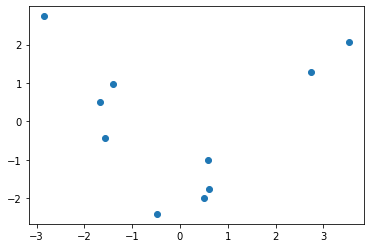

In [22]:
words = ["cat", "dog", "fish", "kitten", "man", "woman",
         "king", "queen", "doctor", "nurse"]

# TODO
pre = glove_model[words]
used = PCA(n_components=2)
tmp = used.fit_transform(pre)
plt.scatter(tmp[:, 0], tmp[:, 1])
plt.show()

## 二、RNN模型搭建

这里参考课件上的代码搭建了一个简单的RNN模型

1. 每次读取一个单词，因此RNN的输入维度为50（即词向量的维度）再加上hidden_size
2. 最终的输出维度为4（对应四个类别）
3. 初始隐状态可以用零向量

有需要的话可以自由修改

In [23]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.i2o = nn.Linear(embedding_dim + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  # 初始化全0的隐状态向量

## 三、模型训练

In [24]:
def train_step(model, batch_data, optimizer, criterion):
    optimizer.zero_grad()
    total_loss = 0
    total_acc = 0

    # 载入数据
    texts, text_lengths = batch_data.text  # texts当中存储的是单词的数字索引
    labels = batch_data.label
        
    #print(labels)
    #print(texts, text_lengths)
    #print(len(text_lengths))
    
    for text, label in zip(texts, labels):
        hidden = model.init_hidden().to(device)  # 创建一个初始隐状态
        # 每次输入batch中的一个样本
        for i in range(len(text)):
            embedding = TEXT.vocab.vectors[text[i]]  # 根据text中的数字索引获得对应的词向量
            embedding = embedding.to(device)
            # print(embedding)
            output, hidden = model(embedding.reshape(1, -1), hidden)  # 变换词向量的维度，使其能和hidden tensor拼接起来
        target = (label - 1).unsqueeze(0)  # 原始label是1~4，减1之后对应下标0~3
        loss = criterion(output, target)   # 计算loss
        loss.backward(retain_graph=True)
        
        total_loss += loss.item()
        
        if output.argmax(1) == label - 1:  # 判断模型预测的概率最大的类是否正确
            total_acc += 1
    
    optimizer.step()
    
    return total_loss / len(batch_data), total_acc / len(batch_data)

在训练过程中，我们希望能够保存效果最好的模型，使用save()和load()函数可以实现模型的保存和加载。

参考文档：https://pytorch.org/tutorials/beginner/saving_loading_models.html

**请实现：保存训练过程中loss最小的模型**

考虑到训练阶段运行时间可能比较长，同学们可以自行选择合适的epoch数。本次作业旨在让大家熟悉基本模型结构，模型最终的表现效果不会成为评分指标。

In [25]:
def train(model, iterator, lr=0.01, num_epoch=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_arr = []
    epoch_loss = []
    # set the model in training phase
    model.train()
    
    for epoch in tqdm(range(num_epoch)):
        mean_acc = []
        mean_loss = []
        for i, batch_data in enumerate(iterator):
            batch_loss, batch_acc = train_step(model, batch_data, optimizer, criterion)
            loss_arr.append(batch_loss)
            mean_loss.append(batch_loss)
            if (i + 1) % 10 == 0:
                print("Iteration number:", i + 1,'Loss:', batch_loss, "Acc:", batch_acc)
            mean_acc.append(batch_acc)
        
        print("Epoch Acc:", np.mean(mean_acc), "Epoch loss", np.mean(mean_loss))

        # TODO: 保存loss最小的模型
        epoch_loss.append(np.mean(mean_loss))
        if np.mean(mean_loss) <= np.min(epoch_loss):
            torch.save(model.state_dict(),'modelparam')
        
    
    # 绘制loss曲线
    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
# RNN训练 具体的参数可以自行调整
n_hidden = 128
n_input = 50
n_output = 4
rnn = RNN(n_input, n_hidden, n_output)
rnn.to(device)
train(rnn, train_iterator, lr=0.0005, num_epoch=10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Iteration number: 10 Loss: 1.352486478164792 Acc: 0.328125
Iteration number: 20 Loss: 1.326682941056788 Acc: 0.421875
Iteration number: 30 Loss: 1.2676816210150719 Acc: 0.421875
Iteration number: 40 Loss: 0.9986333844717592 Acc: 0.609375
Iteration number: 50 Loss: 0.9224279809591776 Acc: 0.546875
Iteration number: 60 Loss: 0.7183096126154851 Acc: 0.703125
Iteration number: 70 Loss: 0.9983469783328474 Acc: 0.625
Iteration number: 80 Loss: 1.2566308546811342 Acc: 0.421875
Iteration number: 90 Loss: 0.9561358471401036 Acc: 0.546875
Iteration number: 100 Loss: 1.0056687770373962 Acc: 0.65625


 10%|████████▎                                                                          | 1/10 [00:32<04:56, 32.96s/it]

Epoch Acc: 0.5320012019230769 Epoch loss 1.0441242310826018
Iteration number: 10 Loss: 0.8204774440382607 Acc: 0.671875
Iteration number: 20 Loss: 0.7405929753076634 Acc: 0.625
Iteration number: 30 Loss: 0.9101921302726055 Acc: 0.640625
Iteration number: 40 Loss: 1.2183565539307892 Acc: 0.390625
Iteration number: 50 Loss: 1.1617222712375224 Acc: 0.484375
Iteration number: 60 Loss: 1.1948953701648861 Acc: 0.46875
Iteration number: 70 Loss: 1.124975296203047 Acc: 0.5625
Iteration number: 80 Loss: 1.1032307678833604 Acc: 0.625
Iteration number: 90 Loss: 1.177717283833772 Acc: 0.453125
Iteration number: 100 Loss: 1.2354629142209888 Acc: 0.515625


 20%|████████████████▌                                                                  | 2/10 [01:05<04:22, 32.85s/it]

Epoch Acc: 0.5172776442307693 Epoch loss 1.0941742171150572
Iteration number: 10 Loss: 1.1449258383363485 Acc: 0.453125
Iteration number: 20 Loss: 1.0436970966402441 Acc: 0.625
Iteration number: 30 Loss: 0.9749948516255245 Acc: 0.609375
Iteration number: 40 Loss: 0.9229581379913725 Acc: 0.671875
Iteration number: 50 Loss: 0.9786398109281436 Acc: 0.578125
Iteration number: 60 Loss: 0.818479654204566 Acc: 0.6875
Iteration number: 70 Loss: 0.6869586984394118 Acc: 0.6875
Iteration number: 80 Loss: 0.8601864181982819 Acc: 0.59375
Iteration number: 90 Loss: 0.8780429134640144 Acc: 0.5625
Iteration number: 100 Loss: 0.6804747848509578 Acc: 0.765625


 30%|████████████████████████▉                                                          | 3/10 [01:37<03:45, 32.26s/it]

Epoch Acc: 0.5862379807692307 Epoch loss 0.961724927700507
Iteration number: 10 Loss: 0.8491950734751299 Acc: 0.65625
Iteration number: 20 Loss: 0.6854450039027142 Acc: 0.75
Iteration number: 30 Loss: 0.7296826975070871 Acc: 0.75
Iteration number: 40 Loss: 0.7499424343113787 Acc: 0.71875
Iteration number: 50 Loss: 0.6641941064044659 Acc: 0.703125
Iteration number: 60 Loss: 0.74025005033036 Acc: 0.703125
Iteration number: 70 Loss: 0.8941821616026573 Acc: 0.625
Iteration number: 80 Loss: 0.7373367840773426 Acc: 0.671875
Iteration number: 90 Loss: 0.7845947383761995 Acc: 0.640625
Iteration number: 100 Loss: 0.7485247830918524 Acc: 0.71875


 40%|█████████████████████████████████▏                                                 | 4/10 [02:08<03:12, 32.02s/it]

Epoch Acc: 0.6684194711538461 Epoch loss 0.8165320788772983
Iteration number: 10 Loss: 0.6667130154382903 Acc: 0.765625
Iteration number: 20 Loss: 0.5484345566164848 Acc: 0.75
Iteration number: 30 Loss: 0.5928865116038651 Acc: 0.765625
Iteration number: 40 Loss: 0.720816370096145 Acc: 0.703125
Iteration number: 50 Loss: 0.6790656763005245 Acc: 0.75
Iteration number: 60 Loss: 0.6622623446110083 Acc: 0.75
Iteration number: 70 Loss: 0.6408080885103118 Acc: 0.8125
Iteration number: 80 Loss: 0.787464671604539 Acc: 0.765625
Iteration number: 90 Loss: 0.5026494972698856 Acc: 0.828125
Iteration number: 100 Loss: 0.6084022070581341 Acc: 0.75


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:40<02:38, 31.79s/it]

Epoch Acc: 0.7295673076923077 Epoch loss 0.7109700828076224
Iteration number: 10 Loss: 0.5519822322385153 Acc: 0.78125
Iteration number: 20 Loss: 0.6400056904722078 Acc: 0.828125
Iteration number: 30 Loss: 0.5012638408181829 Acc: 0.8125
Iteration number: 40 Loss: 0.5462441904383013 Acc: 0.796875
Iteration number: 50 Loss: 0.8310108640580438 Acc: 0.75
Iteration number: 60 Loss: 0.7043104772619699 Acc: 0.6875
Iteration number: 70 Loss: 0.5408395089432361 Acc: 0.796875
Iteration number: 80 Loss: 0.8589706433413085 Acc: 0.734375
Iteration number: 90 Loss: 0.8601559253584128 Acc: 0.703125
Iteration number: 100 Loss: 0.8283165339380503 Acc: 0.640625


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:12<02:07, 31.78s/it]

Epoch Acc: 0.6950120192307693 Epoch loss 0.7539936317034528
Iteration number: 10 Loss: 0.816774177190382 Acc: 0.6875
Iteration number: 20 Loss: 0.9274444585898891 Acc: 0.5625
Iteration number: 30 Loss: 0.9633872676058672 Acc: 0.703125
Iteration number: 40 Loss: 0.7367925399448723 Acc: 0.6875
Iteration number: 50 Loss: 0.7543064185156254 Acc: 0.671875
Iteration number: 60 Loss: 0.6982553353300318 Acc: 0.765625
Iteration number: 70 Loss: 0.743929676595144 Acc: 0.65625
Iteration number: 80 Loss: 0.7883108797432214 Acc: 0.65625
Iteration number: 90 Loss: 0.7190674769449288 Acc: 0.765625
Iteration number: 100 Loss: 0.7000698311803717 Acc: 0.765625


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:45<01:36, 32.26s/it]

Epoch Acc: 0.6651141826923077 Epoch loss 0.8191830792260668
Iteration number: 10 Loss: 0.6826186053876881 Acc: 0.796875
Iteration number: 20 Loss: 0.7156027586671598 Acc: 0.75
Iteration number: 30 Loss: 0.5559330924415917 Acc: 0.765625
Iteration number: 40 Loss: 0.858961079198707 Acc: 0.71875
Iteration number: 50 Loss: 0.600592476911288 Acc: 0.78125
Iteration number: 60 Loss: 0.5973855518514029 Acc: 0.734375
Iteration number: 70 Loss: 0.6855879981957145 Acc: 0.78125
Iteration number: 80 Loss: 0.6704861142738991 Acc: 0.75
Iteration number: 90 Loss: 0.5736353972403094 Acc: 0.8125
Iteration number: 100 Loss: 0.8415496062880266 Acc: 0.71875


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:17<01:04, 32.09s/it]

Epoch Acc: 0.7307692307692307 Epoch loss 0.7046629664420371
Iteration number: 10 Loss: 0.6874974432621457 Acc: 0.703125
Iteration number: 20 Loss: 0.6775937050026073 Acc: 0.765625


## 四、结果评测

计算RNN模型在测试集上的准确率：

In [28]:
def eval_test(model, iterator):
    total_cnt = 0
    total_acc = 0
    for batch_data in iterator:
        texts, text_lengths = batch_data.text
        labels = batch_data.label
        
        for text, label in zip(texts, labels):
            hidden = model.init_hidden().to(device)
            for i in range(len(text)):
                embedding = TEXT.vocab.vectors[text[i]]
                embedding = embedding.to(device)
                output, hidden = model(embedding.reshape(1, -1), hidden)
            
            if output.argmax(1) == label - 1:  # 判断预测概率最大的类是否正确
                total_acc += 1
            total_cnt += 1

    print("Test Acc:", total_acc / total_cnt)

**请加载效果最好的模型，输出模型在测试集上的准确率**

In [30]:
# TODO
rnn.load_state_dict(torch.load('modelparam'))
eval_test(rnn,test_iterator)

Test Acc: 0.752


## 五、附加部分（1'）

**可选1 模型优化**：在上述文本分类任务中，只使用了文章的正文内容，没有利用标题中的信息。请尝试加入标题内容，修改模型，以优化模型的分类能力。

**可选2 对抗实验**：训练完成后，我们可以得到一个模型能够正确预测的样本构成的集合，请在已有的模型能够正确分类的样本集中设计一些对抗实验。

例如：对原始的输入文本随机删去一些词，或是将部分词遮盖（替换）成&lt;unk&gt;，表示未知词。（前面用torchtext构建的TEXT.vocab词表中第一个token是&lt;unk&gt;）

这部分可以设置一个适当的比例，比如遮盖/删除20%的词。计算模型对于这样的输入的预测错误率，并尝试改进策略，使得模型在面对“20%的词被遮盖”（或者其他条件）的情况时，错误预测率尽可能低。